<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/Solar_PHS_gasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pymoo used for optimization
from IPython.display import clear_output
!pip install pymoo
clear_output()

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

In [4]:
# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv(r'C:\Users\Asus\Desktop\Gasification files\GA\HOURLY_DATA_new.csv')
# df = df[0:100]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [5]:
df.describe()

,Unnamed: 0,ghi,air_temperature,deficit_energy
count,183960.000000,183960.000000,183960.000000,1.839600e+05
mean,91979.500000,0.218271,11.596737,2.363686e+05
std,53104.822097,0.311458,8.223487,4.957133e+05
min,0.000000,0.000000,-8.630000,-1.302164e+06
25%,45989.750000,0.000000,4.888750,-1.272546e+05
50%,91979.500000,0.005384,12.802500,1.943938e+05
75%,137969.250000,0.403645,17.676667,5.229730e+05
max,183959.000000,1.147850,29.931667,2.140979e+06


In [6]:
'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

pump_cost_unit = 1075 #usd/kW
pump_OM = 0.01075 #usd/kW.year

reservoir_cost_unit = 170 #usd/m2
reservoir_OM = 1.7 #usd/m3.year

turbine_cost_unit = 1000 #usd/kw
turbine_OM = 0.01 #usd/kw

#single site phs(1GWh)
reservoir_max = 10000000 #m3
reservoir_area = 5000000 #m2
h3 = 50 #m(minimum head)
h2_max = reservoir_max/reservoir_area #maximum reservior head
density = 1000 #kg/m3(water)
g = 9.8 #m/s2
ntur = 0.7 #efficiency of turbine
npum = 0.7 #efficiency of pump

In [7]:
Q_res = reservoir_max/3600
turbine_max = Q_res*density*g*(h3+h2_max)*ntur/1000
pump_max = Q_res*density*g*(h3+h2_max)*npum/1000

In [8]:
'''
    Calculating the cost of the hybrid energy system.
'''
def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  # print(solar_cost)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  # print(gasifier_cost)
  return gasifier_cost

def cost_pump(pump):
  pump_cost_woelec = pump*((CRF*pump_cost_unit)+pump_OM)
  # pump_elec_op = pump_elec*0.04*CRF
  pump_cost = pump_cost_woelec#+pump_elec_op
  return pump_cost

def cost_reservoir(reservoir_vol):
  reservoir_cost = reservoir_area*reservoir_cost_unit*CRF + reservoir_vol*reservoir_OM
  return reservoir_cost

def cost_turbine(turbine):
  turbine_cost = turbine*((CRF*turbine_cost_unit)+turbine_OM)
  return turbine_cost

def LCOE(total_energy_prod, solar, gasifier, pump, reservoir, turbine):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_pump(pump)+cost_reservoir(reservoir)+cost_turbine(turbine)
  energy_prod_per_year = total_energy_prod/N
  LCOE = ASC/energy_prod_per_year
  return ASC, LCOE

In [9]:
'''
    Calculating the energy produced by the solar panel and gasifier.
'''
def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

In [10]:
def turbine_energy(turbine, reservior_lev):
  'maximum energy produced by phs turbine'
  Qt_rated = turbine*1000/(density*g*(h3+h2_max)*ntur) # turbine throughput
  res_Qt = reservior_lev/3600 #maximum Qt available from reservior
  Qt = min(Qt_rated, res_Qt)
  energy_prod = Qt*ntur*density*g*(h3+(reservior_lev/reservoir_area))
  return energy_prod/1000

def turbine_discharge(energy, reservior_lev):
  Qdis = energy*1000/(ntur*density*g*(h3+(reservior_lev/reservoir_area)))
  Qdis_hr = Qdis*3600
  return Qdis_hr

def pump_energy(pump, Pch_t, reservior_lev):
  Qp_rated = pump*1000/(density*g*(h3+h2_max)*npum) # pump throughput
  res_Qp = (reservoir_max-reservior_lev)/3600 #maximum Qp available from reservior
  Qp = min(Qp_rated, res_Qp)
  Ep = Qp*density*g*(h3+reservior_lev/reservoir_area)/npum
  Edump = 0
  Ep = Ep/1000
  if Ep>=Pch_t:
    Ep = Pch_t
    Edump = 0
  else:
    Ep = Ep
    Edump = Pch_t-Ep
  return Ep, Edump

def pump_discharge(energy, reservoir_lev):
  energy = energy*1000
  Qdis = npum*energy/(density*g*(h3+(reservoir_lev/reservoir_area)))
  Qdis_hr = Qdis*3600
  return Qdis_hr

In [11]:
'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, reservoir_lev, reservoir_max, pump, turbine,  solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  reservoir_lev_up = reservoir_lev
  turbine_supply = 0


  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)
  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run PHS and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and fuelcell
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if reservoir_lev>0:
        if req_energy<=(turbine_energy(turbine, reservoir_lev)):
          '''
          req_energy met by only fuelcell
          '''
          turbine_supply = req_energy
          energy_served+=turbine_supply
          reservoir_lev_up = reservoir_lev-turbine_discharge(turbine_supply, reservoir_lev)

        else:
          '''
          req_energy met by fuelcell and gasifier
          '''
          gasifier_E_req = req_energy-(turbine_energy(turbine, reservoir_lev))
          turbine_supply = turbine_energy(turbine, reservoir_lev)
          energy_served+=turbine_supply
          reservoir_lev_up = reservoir_lev-turbine_discharge(turbine_supply, reservoir_lev)
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            pass
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            # print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          pass
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          # print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")
    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used in electrolyser for hydrogen production.
      '''
      energy_served+=energy_def  # solar panel served the entire deficit energy
      Pch_t = solar_energy-energy_def  # extra energy from solar used for PHS charge


      Ep, Edump = pump_energy(pump, Pch_t, reservoir_lev)
      reservoir_lev_up = reservoir_lev+pump_discharge(Ep, reservoir_lev)
      energy_served+=Edump

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy #solar energy already calculated outside loop
    surplus_ene = abs(energy_def)#make hydrogen from this
    Pch_t = solar_energy-energy_def  # extra energy from solar used for PHS charge


    Ep, Edump = pump_energy(pump, Pch_t, reservoir_lev)

    reservoir_lev_up = reservoir_lev+pump_discharge(Ep, reservoir_lev)
    energy_served+=Edump


  return energy_served, turbine_supply, reservoir_lev_up, solar_energy, gasifier_energy

In [12]:
'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:
      # print(design)
      solar, gasifier, pump, turbine = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      reservoir_lev = reservoir_max

      for i in range(len(df)):
        Energy_served, turbine_supply, reservoir_lev, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i], reservoir_lev=reservoir_lev, reservoir_max=reservoir_max, pump=pump, turbine=turbine, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1
          break
      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, pump, reservoir_max, turbine)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=4, n_obj=1, n_eq_constr=1, xl=[0, 0, 0, 0], xu=[7440937, 2360000, int(pump_max), int(turbine_max)],vtype=int)

In [13]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
algorithm = GA(pop_size=20,
               sampling=IntegerRandomSampling(),
               crossover=SBX(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               mutation=PM(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 50)

In [14]:
%%time
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   verbose=True,
                   seed=42,
                   save_history=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  0.9999000000 |  0.9999000000 |             - |             -
     2 |       40 |  0.9999000000 |  0.9999000000 |             - |             -
     3 |       60 |  0.9999000000 |  0.9999000000 |             - |             -
     4 |       80 |  0.000000E+00 |  0.8499150000 |  0.0858709099 |  0.0720186279
     5 |      100 |  0.000000E+00 |  0.6499350000 |  0.0867720265 |  0.0720186279
     6 |      120 |  0.000000E+00 |  0.4499550000 |  0.0861434301 |  0.0720186279
     7 |      140 |  0.000000E+00 |  0.000000E+00 |  0.0780356748 |  0.0712260143
     8 |      160 |  0.000000E+00 |  0.000000E+00 |  0.0730748099 |  0.0712260143
     9 |      180 |  0.000000E+00 |  0.000000E+00 |  0.0716840998 |  0.0699447466
    10 |      200 |  0.000000E+00 |  0.000000E+00 |  0.0713275426 |  0.0691129092
    11 |      220 |  0.000000E+00 |  0.000000E+00 |  0.0709072701 |  0.0691129092
    12 |      24

In [16]:
'''
Optimized results for SOO.
'''
solar, gasifier, pump, turbine = results.X
print(f"Solar:{solar}KW, Gasifier: {gasifier}KW, Pump: {pump}KW, Turbine: {turbine}KW || LCOE: {results.F}USD/KWh")
print(pump_max,turbine_max)

Solar:7440910KW, Gasifier: 2119935KW, Pump: 90895KW, Turbine: 141180KW || LCOE: [0.06837862]USD/KWh
990888.888888889 990888.888888889


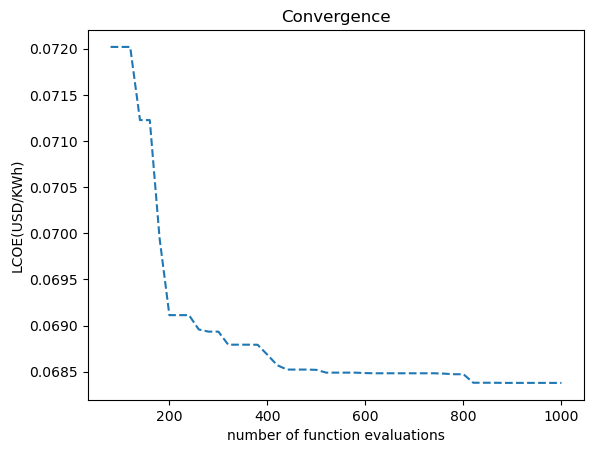

In [17]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in results.history])
opt = np.array([e.opt[0].F for e in results.history])

plt.title("Convergence")
plt.plot(n_evals[3:], opt[3:], "--")
plt.xlabel("number of function evaluations")
plt.ylabel("LCOE(USD/KWh)")
plt.show()

In [20]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
solar, gasifier, pump, turbine = results.X
# solar, gasifier, battery = 3717620.230751795, 2209925.35022830, 4446649.505009017

# Solar:3717620.230751795KW, Gasifier: 2209925.350228307KW, Battery: 4446649.505009017KWh || LCOE: [0.12784646]USD/KWh

solar_array = []
gasifier_array = []
turbine_array = []
deficit_array = []
reservoir_array = []

total_supply = []

count = 0
gasifier_up_hr = 0
gasifier_energy = 0
Energy_prod_N = 0
reservoir_lev = reservoir_max
count = 0
Energy_prod_N = 0 #total energy throughout the project life produced
reservoir_lev = reservoir_max

# for i in range(len(df)):
for i in range(8760):

  Energy_served, turbine_supply, reservoir_lev, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i], reservoir_lev=reservoir_lev, reservoir_max=reservoir_max, pump=pump, turbine=turbine, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy+=gasifier_ene

  if round(gasifier_ene, 2)>0:
    gasifier_up_hr+=1

  energy_tot = df['deficit_energy'][i]+Energy_served
  energy_tot = round(energy_tot, 4)
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  turbine_array.append(turbine_supply)
  reservoir_array.append(reservoir_lev)
  total_supply.append(Energy_served)
asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, pump, reservoir_max, turbine)
print(asc, lcoe)
print(np.array(turbine).max())
print(gasifier_up_hr)
print(gasifier_energy)

1042667827.391128 1.5029303263014617
141180
2507
962689937.5699722


In [21]:
gasifier_energy/(5*0.55*1000*1000000)

0.3500690682072626

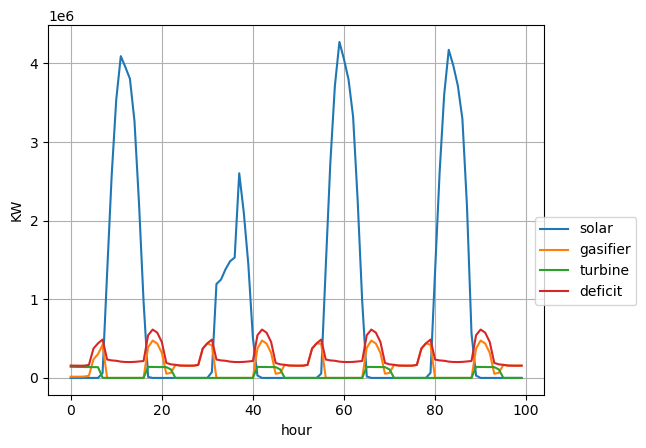

In [26]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
i = 0 # start hour
j = 100# end hour
x = np.arange(i,j)
plt.plot(x,solar_array[i:j], label='solar')
plt.plot(x,gasifier_array[i:j], label='gasifier')
plt.plot(x,turbine_array[i:j], label = 'turbine')
plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit')
# plt.plot(x, reservoir_array[i:j], label='reservoir')
# plt.plot(x,np.array(deficit_array[i:j]), label = 'surplus')
plt.xlabel("hour")
plt.ylabel("KW")
# plt.plot(x,total_supply[i:j], label = 'total')
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=(1.2,0.5))

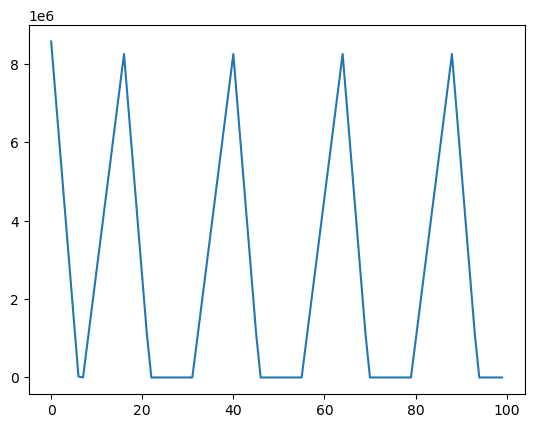

In [24]:
plt.plot(x, reservoir_array[i:j], label='reservoir')